#### Consider the anisotropies introduced by the Kaiser window function convolution

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['kaiser']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
R_max = 400

In [63]:
from scipy.special import i0,spherical_jn
from scipy.integrate import quad
def kaiser(x,alpha_kaiser=3):
    return i0(alpha_kaiser*np.pi*np.sqrt(1.-x**2.))/i0(alpha_kaiser*np.pi)
def window(r,R_max):
    if type(r)==float:
        if r<R_max:
            return kaiser(r/R_max)
        else:
            return 0.
    else:
        out = np.zeros_like(r)
        filt = np.where(r<R_max)
        out[filt]=kaiser(r[filt]/R_max)
        return out
def spherical_FT(k,R_max):
    out=quad(lambda r: spherical_jn(0,k*r)*r**2.*window(r,R_max),0,R_max)
    return out[0]*np.pi*4.

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


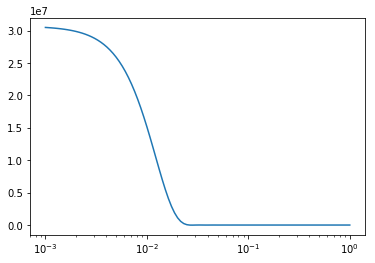

In [64]:
k_all = np.logspace(-3,0,100)
fts = [spherical_FT(kk,R_max) for kk in k_all]
plt.plot(k_all,fts)
plt.xscale('log');

#### Create 3D window function

In [65]:
def window_3d(x,y,z):
    r = np.sqrt(x**2.+y**2.+z**2.)
    return window(r,R_max)

In [127]:
## Load in power
power_in = np.load('true_k_iso_model.npz')
k_in = power_in['k'];power_model = power_in['power']

In [175]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(k_in,power_model)
def power_1d(k):
    return spl(k)

In [176]:
def power_3d(kx,ky,kz):
    k = np.sqrt(kx**2.+ky**2.+kz**2.)
    mu = np.sqrt(kx**2.+ky**2.)/k
    f=0.3
    return power_1d(k)*(1.+0.3*mu**2.)**2.

In [196]:
k_all = np.linspace(-0.5,0.5,500)
power_grid = np.zeros([len(k_all),len(k_all),len(k_all)])
for i in range(len(k_all)):
    for j in range(len(k_all)):
        power_grid[i,j,:]=power_3d(k_all[i],k_all[j],k_all)

In [197]:
ifft_power_grid=np.fft.fftshift(np.fft.ifftn(power_grid))
r_all=np.fft.fftshift(np.fft.fftfreq(len(k_all),d=k_all[1]-k_all[0]))

In [198]:
window_grid = np.zeros([len(r_all),len(r_all),len(r_all)])
for i in range(len(r_all)):
    for j in range(len(r_all)):
        window_grid[i,j,:]=window_3d(r_all[i],r_all[j],r_all)

In [199]:
prod_ifft = ifft_power_grid*window_grid
convolved_power = np.fft.fftshift(np.fft.fftn(prod_ifft))

In [212]:
k_grid = np.meshgrid(k_all,k_all,k_all)[0]

In [217]:
from scipy.interpolate import RegularGridInterpolator
convolved_model = RegularGridInterpolator([k_all,k_all,k_all],convolved_power)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


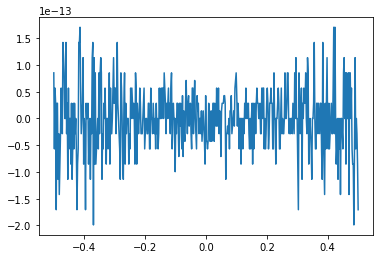

In [226]:
cc=[convolved_model([0.,0.,kk]) for kk in k_all]
plt.plot(k_all,cc)

In [ ]:
binned_power = np.zeros([3,len(k_all)-1])
for i in range(len(k_all)):
    for j in range(len(k_all)):
        kij = np.sqrt(k_all[i]**2.+k_all[j]**2.)
        for k in range(len(k_all)):
            this_k = np.sqrt(k_all[i]**2.+k_all[j]**2.+k_all[k]**2.)
            mu_k = kij/this_k
            for l_i,ell in enumerate([0,2,4]):
                k_bin = np.where((this_k<k_all[1:])&(this_k>k_all[:-1]))
                binned_power[l_i,k_bin]+=(2.*ell+1.)*

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


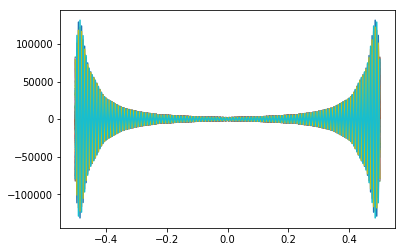

In [195]:
plt.plot(k_all,convolved_power[0,:,:])

In [79]:
r_all = np.linspace(-400,400,201)
window_grid = np.zeros([len(r_all),len(r_all),len(r_all)])

In [80]:
for i in range(len(r_all)):
    for j in range(len(r_all)):
        window_grid[i,j,:]=window_3d(r_all[i],r_all[j],r_all)

In [82]:
fft_window_grid=np.fft.fftn(window_grid)
k_grid=np.fft.fftfreq(len(r_all),d=r_all[1]-r_all[0])

In [39]:
k_all = np.linspace(0.0,0.5,101)
k_grid=np.meshgrid(k_all,k_all,k_all)

In [40]:
k_grid

[array([[[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         [0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005],
         [0.01 , 0.01 , 0.01 , ..., 0.01 , 0.01 , 0.01 ],
         ...,
         [0.49 , 0.49 , 0.49 , ..., 0.49 , 0.49 , 0.49 ],
         [0.495, 0.495, 0.495, ..., 0.495, 0.495, 0.495],
         [0.5  , 0.5  , 0.5  , ..., 0.5  , 0.5  , 0.5  ]],
 
        [[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         [0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005],
         [0.01 , 0.01 , 0.01 , ..., 0.01 , 0.01 , 0.01 ],
         ...,
         [0.49 , 0.49 , 0.49 , ..., 0.49 , 0.49 , 0.49 ],
         [0.495, 0.495, 0.495, ..., 0.495, 0.495, 0.495],
         [0.5  , 0.5  , 0.5  , ..., 0.5  , 0.5  , 0.5  ]],
 
        [[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         [0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005],
         [0.01 , 0.01 , 0.01 , ..., 0.01 , 0.01 , 0.01 ],
         ...,
         [0.49 , 0.49 , 0.49 , ..., 0.49 , 0.49 , 0.49 ],
         [0.495, 0.495, 